In [47]:
import pandas as pd
import shap
import xgboost
from sklearn.preprocessing import OneHotEncoder
from loguru import logger
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data Preprocessing

In [48]:
# Read in data 
df = pd.read_csv('data/life_expectancy.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3306 entries, 0 to 3305
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country Name                    3306 non-null   object 
 1   Country Code                    3306 non-null   object 
 2   Region                          3306 non-null   object 
 3   IncomeGroup                     3306 non-null   object 
 4   Year                            3306 non-null   int64  
 5   Life Expectancy World Bank      3118 non-null   float64
 6   Prevelance of Undernourishment  2622 non-null   float64
 7   CO2                             3154 non-null   float64
 8   Health Expenditure %            3126 non-null   float64
 9   Education Expenditure %         2216 non-null   float64
 10  Unemployment                    3002 non-null   float64
 11  Corruption                      975 non-null    float64
 12  Sanitation                      20

In [49]:
pd.DataFrame(df.isna().sum() / len(df), columns=['% missing']).sort_values('% missing', ascending=False)

,% missing
Corruption,0.705082
Sanitation,0.377193
Education Expenditure %,0.329704
Prevelance of Undernourishment,0.206897
Unemployment,0.091954
Life Expectancy World Bank,0.056866
Health Expenditure %,0.054446
CO2,0.045977
Country Name,0.000000
Country Code,0.000000


In [50]:
# I do want to drop the rows with missing values for the target varaible Life expectancy
df = df.dropna(subset=["Life Expectancy World Bank"])
pd.DataFrame(df.isna().sum() / len(df), columns=['% missing']).sort_values('% missing', ascending=False)

,% missing
Corruption,0.697563
Sanitation,0.363695
Education Expenditure %,0.312059
Prevelance of Undernourishment,0.164849
Health Expenditure %,0.045542
Unemployment,0.037203
CO2,0.024375
Country Name,0.000000
Country Code,0.000000
Region,0.000000


Seeing as the goal here is to play around more with SHAP, I'm going to make the data cleaning relatively swift and simple. Consequently, with Corruption missing 70% of the data, I'm going to simply drop that for now (could convert it to binary feature as well). I'm also going to be dropping `Country Code` and `Country Name` as they are not adding anything to the model itself.

In [51]:
df = df.drop(["Country Code", "Country Name", "Corruption"], axis=1)

Now that we have all the columns of interest in the dataframe, let's get the numeric and non-numeric columns.

In [52]:
# Numeric columns
numeric_cols = list(df.select_dtypes(include=['number']).columns)

# Categorical columns
categorical_cols = list(df.select_dtypes(include=['object']).columns)

logger.info(f"Numeric columns: {numeric_cols}")
logger.info(f"Categorical columns: {categorical_cols}")

2023-09-16 16:30:09.628 | INFO     | __main__:<module>:7 - Numeric columns: ['Year', 'Life Expectancy World Bank', 'Prevelance of Undernourishment', 'CO2', 'Health Expenditure %', 'Education Expenditure %', 'Unemployment', 'Sanitation', 'Injuries', 'Communicable', 'NonCommunicable']
2023-09-16 16:30:09.629 | INFO     | __main__:<module>:8 - Categorical columns: ['Region', 'IncomeGroup']


Since I want to do this cleaning swiftly, I'm going to simply impute the mean value for each missing value.

In [53]:
# Impute mean on missing values
df = df.fillna(df.mean(numeric_only=True))
df.isna().sum()

Region                            0
IncomeGroup                       0
Year                              0
Life Expectancy World Bank        0
Prevelance of Undernourishment    0
CO2                               0
Health Expenditure %              0
Education Expenditure %           0
Unemployment                      0
Sanitation                        0
Injuries                          0
Communicable                      0
NonCommunicable                   0
dtype: int64

Now, we'll convert our categorical features to dummy variables.

In [54]:
# Set the features to encode - I'm going to include year here as well
features = ["Region", "IncomeGroup", "Year"]

# Encode the features and store them in a new pandas dataframe
onehotencoder = OneHotEncoder(sparse_output=False)
transformed_data = onehotencoder.fit_transform(df[features])
encoded_data = pd.DataFrame(transformed_data, index=df.index, columns=onehotencoder.get_feature_names_out(features))

# Concatenate the original dataframe and the encoded dataframe
concatenated_data = pd.concat([df, encoded_data], axis=1).reset_index(drop=True)
df_clean = concatenated_data.drop(columns=features, axis=1)

As a final step, I will standardize the numerical columns left.

In [55]:
try:
	numeric_cols.remove('Year')
	numeric_cols.remove('Life Expectancy World Bank')
except ValueError:
	logger.info("Year already removed from numeric columns")

# Create standard scaler
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])
df_clean.head()

,Life Expectancy World Bank,Prevelance of Undernourishment,CO2,Health Expenditure %,Education Expenditure %,Unemployment,Sanitation,Injuries,Communicable,NonCommunicable,...,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019
0,56.308,3.588289,-0.209376,0.000000,0.000000,0.474352,0.000000,0.145976,0.249164,-0.067766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.059,5.493770,-0.189759,-0.693189,0.000000,-0.631783,0.000000,-0.001033,0.328394,-0.171693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74.288,-0.561209,-0.206156,0.370809,-0.686314,1.736695,-0.497525,-0.239003,-0.254834,-0.242412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,74.544,-0.764331,-0.085119,-1.494047,0.000000,-0.877392,0.000000,-0.233852,-0.258825,-0.244091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73.755,-0.744986,-0.048976,0.864458,0.201327,1.532698,-0.180049,0.000012,-0.182721,0.007742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ok, now our data is all clean and we can move on to modeling (and consequently SHAP)!

# Modeling/SHAP

Prior to modeling, we'll split our data into training and testing sets.

In [56]:
X, y = df_clean.drop(columns=["Life Expectancy World Bank"]), df_clean["Life Expectancy World Bank"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
[16:30:15] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be rem

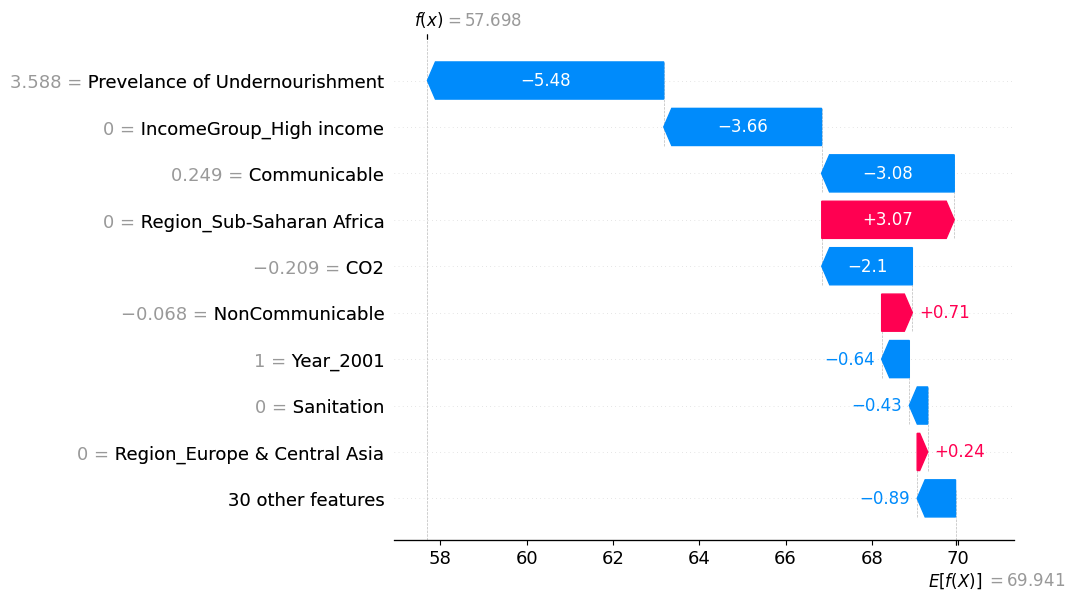

In [57]:
# Train a simple XGBoost model
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


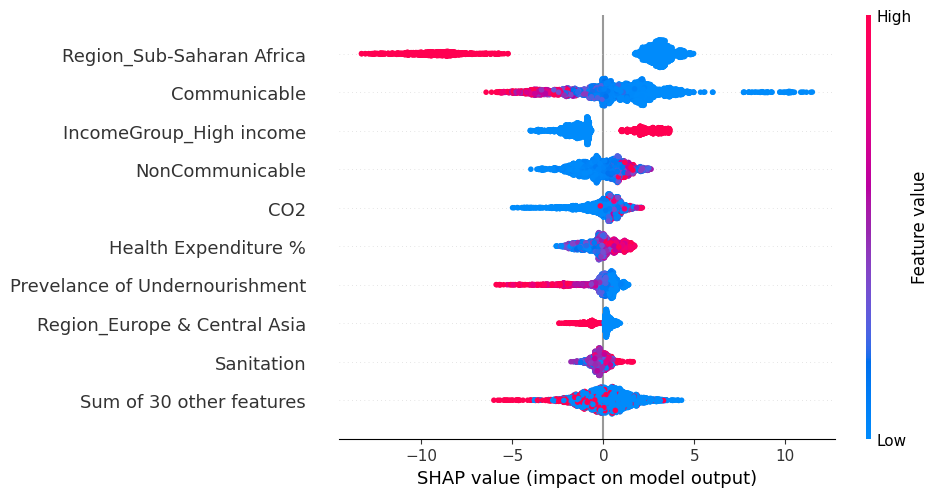

In [58]:
shap.plots.beeswarm(shap_values)

In [60]:
df_clean[df_clean['Region_Sub-Saharan Africa'] == 1]

836